<p align="center">
    <img width=210 height=150 src="../reports/figures/cunef_bw.png">
</p>

<div>
<h1>1.0 Initial Data Exploration (EDA) </h1>
Fake News Classifier <br>
<strong>Ciencia de Datos para la Información No Estructurada</strong> <br>
<strong>Master Universidatio en Ciencia de Datos</strong>
</div>

<div style='text-align:right'>Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>

---

En este notebook nos centramos en entender y analizar los datos a utilizar para elaborar el modelo de detección de noticias falsas. Para ello procederemos a identificar las principales características del conjunto de datos y determinar como podemos utilizarlo y procesarlo para crear el modelo final. 

In [1]:
# Libraries
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
import re
import string
from sklearn import preprocessing
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

In [2]:
#nltk.download('punkt')
#nltk.download('stopwords')

### Lectura y análisis preliminar
Procedemos a leer y visualizar los primeros cinco valores del dataset original a utilizar...

In [3]:
# Data reading
raw_data_df = pd.read_csv("../data/raw/fake_or_real_news.csv")

In [4]:
raw_data_df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Observamos que los datos se componen de 4 campos, cada registro posee un valor identificativo (id), el título de la noticia, el contenido del mismo y la etiqueta, es decir, nuestra variable objetivo que nos muestra si la noticia es verdadera o falsa.

Procedemos a determinar las características sobre todo el conjunto de datos de la variable objetivo, centrándonos en su proproción en totat...

Nos diseñamos una función para obtener un resumen de la composición del dataset

In [5]:
def classes_overview(df = None, obj_val = ""):
    '''
    Devuelve un dataframe con el porcentaje y valor abosoluto de las clases de la variable objetivo.
    :param df: Datase
    :param obj_val: Variable objetivo
    :return: Dataframe
    '''
    temp = df[obj_val].value_counts(normalize=True).mul(100).rename('percentaje').reset_index()
    temp_conteo = df[obj_val].value_counts().reset_index()
    return pd.merge(temp, temp_conteo, on=['index'], how='inner')

In [6]:
classes_overview(raw_data_df, 'label')

,index,percentaje,label
0,REAL,50.055249,3171
1,FAKE,49.944751,3164


Observamos como la proporción de los datos es bastante equilibrada, lo que simplifica bastante la tarea de división del dataset a no ser necesario tener en cuenta una desequelibrio a la hora de entrenar el modelo.

### División de train y test

Previamente a continuar con el análisis vamos a realizar la division de los datos en muestra de train (entrenamiento) y test...

In [7]:
# We divide values of the target label and the rest of data
X = raw_data_df.drop('label', axis=1)
Y = raw_data_df['label']

# We make the split between train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=1234, stratify=Y)

# We save the original data divided
train_data_df = X_train
train_data_df['label'] = Y_train
train_data_df.to_csv("../data/interim/train.csv")

test_data_df = X_test
test_data_df['label'] = Y_test
test_data_df.to_csv("../data/interim/test.csv")


### Análisis detallado de los datos
Una vez realizada la separación procedemos a realizar el análisi de los datos. Nos centramos únicamente en la muestra de entrenamiento (train).

In [8]:
print('Total de muestras del dataset: ', len(train_data_df.index))

Total de muestras del dataset:  5384


Tenemos un total de 5384 muestras, vamos a verificar que el balanceo del dataset es adecuado otra vez después de la división de train y test...

In [9]:
# We check the balance of the dataset again to be sure the balance is correct
classes_overview(train_data_df, 'label')

,index,percentaje,label
0,REAL,50.055721,2695
1,FAKE,49.944279,2689


Observamos que el buen balanceo del dataset se mantiene, teniende un 50% para noticias reales y otro 50% de noticias falsas aproximadamente. Ahora nos centramos en distintos aspectos a evaluar.

**Primero**. Comprobamos que no hay valores nulos...

In [10]:
# We check the existance of anomalies in the data like NULL values
temp_df = train_data_df.isnull().sum().reset_index()
temp_df.columns = ['column_name', 'NAs']
temp_df

,column_name,NAs
0,Unnamed: 0,0
1,title,0
2,text,0
3,label,0


Observamos que no existen valores nulos en los datos, por lo que no es necesario eliminar o tratar estos. 

**Segundo**. Comprobamos si pueden existir noticias repetidas...

In [11]:
# We check any duplicates
sum(train_data_df.duplicated())

0

Observamos que no hay noticias repetidas en los datos y contamos con noticias diferentes para poder entrenar.

### Procesado
Realizamos un primer procesado de los datos con el objetivo de poder realizar más análisis y a la vez preparar los datos para el modelado. 

Comenzaremos con la variable objetivo, la etiqueta de noticia falsa y verdadera. Haremos uso de un encoding de etiquetas: Label Encoding, esto sustituirá FAKE por 0 y REAL por 1

In [12]:
lb = preprocessing.LabelEncoder()
train_data_df['label'] = lb.fit_transform(train_data_df['label'])
print(lb.classes_)

# Repeat encoding for test sample
test_data_df['label'] = lb.transform(test_data_df['label'])

['FAKE' 'REAL']


In [13]:
train_data_df

,Unnamed: 0,title,text,label
1342,8196,Voter Dreading Being Sent Over To Visibly Stup...,Trump Raises Concern Over Members Of Urban Com...,0
1251,30,Abortion bill dropped amid concerns of female ...,This item has been updated.\n\nHouse Republica...,1
804,7216,Internet Is On Fire With Speculation That Pode...,We Are Change \nEmails revealed by Wikileaks f...,0
47,587,Senate race rankings: Dems attack as GOP lays ...,The move would make it easier for the Trump ad...,1
3888,103,Starbucks baristas stop writing 'Race Together...,In a marketing fiasco that could rank right up...,1
...,...,...,...,...
502,1118,Romney's timely Trump trolling,**Want FOX News First in your inbox every day?...,1
2824,4423,Megyn Kelly interrogates Tom Cotton on Iran le...,"On Monday, Cotton drafted a letter — signed by...",1
1768,9347,CONTROVERSIAL NEW ‘ANTI-FAMINE’ GMO POTATO STR...,Home › HEALTH | US NEWS › CONTROVERSIAL NEW ‘A...,0
4116,6239,"Meter Reader Knocks On Man’s Door, Reveals Sin...",Share This \nWhen a man heard a knock on his d...,0


Ahora procedemos a limpiar los títulos y textos de las noticias, observamos en un primer vistazo varios signos de puntuación, símbolos y otros signos utilizados para indicar espacios en programación (ej. \n), procedemos a homgeneizar los datos a minusculas, eliminando espacios, sustituyendo puntuaciones mediante el uso de traducciones y expresiones regulares.

In [14]:
translator = str.maketrans('', '', string.punctuation)
train_data_df['proc_title'] = train_data_df.title.map(lambda x : re.sub(r"[^a-zA-Z0-9]", " ",x.strip().lower().translate(translator)))
train_data_df['proc_text'] = train_data_df.text.map(lambda x : re.sub(r"[^a-zA-Z0-9]", " ",x.strip().lower().translate(translator)))

test_data_df['proc_title'] = test_data_df.title.map(lambda x : re.sub(r"[^a-zA-Z0-9]", " ",x.strip().lower().translate(translator)))
test_data_df['proc_text'] = test_data_df.text.map(lambda x : re.sub(r"[^a-zA-Z0-9]", " ",x.strip().lower().translate(translator)))

In [15]:
train_data_df['proc_title']

1342    voter dreading being sent over to visibly stup...
1251    abortion bill dropped amid concerns of female ...
804     internet is on fire with speculation that pode...
47      senate race rankings dems attack as gop lays s...
3888    starbucks baristas stop writing race together ...
                              ...                        
502                         romneys timely trump trolling
2824    megyn kelly interrogates tom cotton on iran le...
1768    controversial new  antifamine  gmo potato stra...
4116    meter reader knocks on man s door reveals sini...
4944     on contact  chris hedges and medea benjamin o...
Name: proc_title, Length: 5384, dtype: object

Una vez limpiado el texto vamos realizar un análisis de las palabras contenidas para determinar relaciones y visualizar aspectos interesantes y comunes según la variable objetivo. Primero lo haremos con los títulos de las noticias...

In [16]:
corpus_fake = ' '.join(train_data_df[train_data_df['label'] == 0].proc_title)
all_words_fake = word_tokenize(corpus_fake)
corpus_true = ' '.join(train_data_df[train_data_df['label'] == 1].proc_title)
all_words_true = word_tokenize(corpus_true)

# Cleaning all stopwords
stopwords = nltk.corpus.stopwords.words('english')
all_words_fake = [word for word in all_words_fake if word not in stopwords]
all_words_true = [word for word in all_words_true if word not in stopwords]

Veamos que palabras son más comunes en cada caso...

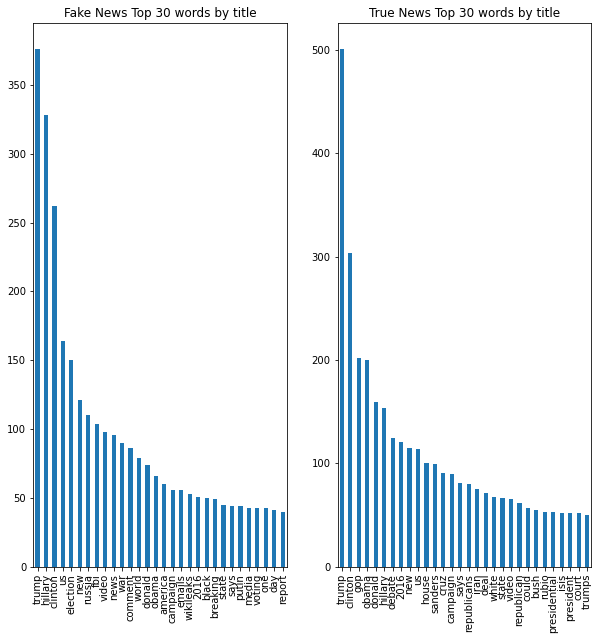

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharey=False)
ax1 = pd.Series(Counter(all_words_fake)).sort_values(ascending=False).iloc[:30].plot(kind="bar", ax=axes[0]);
ax1.title.set_text("Fake News Top 30 words by title")
ax2 = pd.Series(Counter(all_words_true)).sort_values(ascending=False).iloc[:30].plot(kind="bar", ax=axes[1]);
ax2.title.set_text("True News Top 30 words by title")

Observamos como existen varias palabras comunes en ambos tipos de noticias, sin embargo tienen distinta frecuencia de aparición según el tipo de noticia. Por otro lado al ser noticias de misma tipología no resulta extraña esta similitud. 

Veamos por otro lado las longitudes de los títulos...

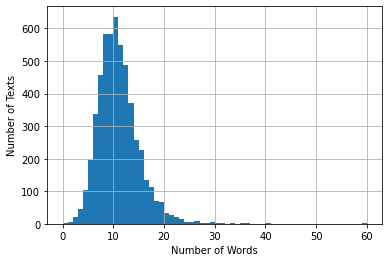

In [18]:
titles_len = [len(i.split()) for i in train_data_df['proc_title']]

pd.Series(titles_len).hist(bins = 60);
plt.xlabel('Number of Words');
plt.ylabel('Number of Texts');

Ahora repetiremos este análisis con el contenido de las noticias...

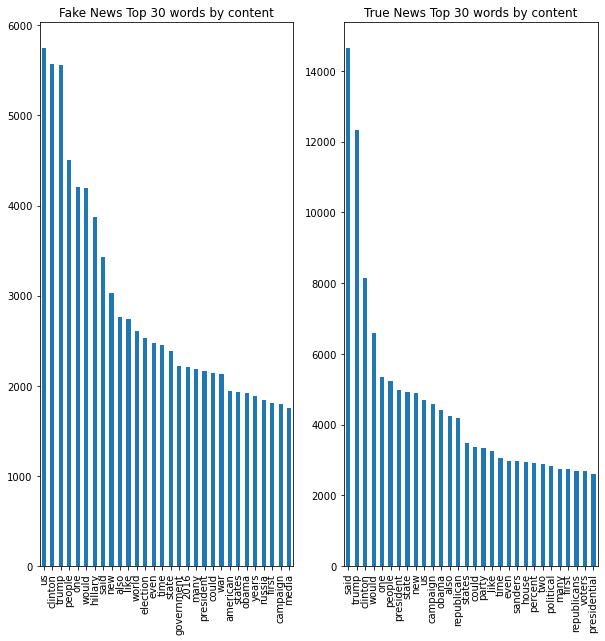

In [19]:
corpus_fake = ' '.join(train_data_df[train_data_df['label'] == 0].proc_text)
all_words_fake = word_tokenize(corpus_fake)
corpus_true = ' '.join(train_data_df[train_data_df['label'] == 1].proc_text)
all_words_true = word_tokenize(corpus_true)

# Cleaning all stopwords
stopwords = nltk.corpus.stopwords.words('english')
all_words_fake = [word for word in all_words_fake if word not in stopwords]
all_words_true = [word for word in all_words_true if word not in stopwords]

fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharey=False)
ax1 = pd.Series(Counter(all_words_fake)).sort_values(ascending=False).iloc[:30].plot(kind="bar", ax=axes[0]);
ax1.title.set_text("Fake News Top 30 words by content")
ax2 = pd.Series(Counter(all_words_true)).sort_values(ascending=False).iloc[:30].plot(kind="bar", ax=axes[1]);
ax2.title.set_text("True News Top 30 words by content")

Podemos observar como las palabras son bastante comunes en ambos casos, siendo las primeras ocurrencias casi iguales a las de los títulos. 

---

<div style='text-align:center'> Elaborado por Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>